# 作業重點:

(1) 以 Adam 為例, 調整 batch_size, epoch, 觀察 accuracy, loss 的變化

(2) 以同一模型, 分別驗證 SGD, Adam, RMSprop 的 accuracy

# 作業目標:
    
    取得各種優化器的運算結果

In [1]:
from __future__ import print_function
import keras
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
import os
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt

In [2]:
# Blas GEMM launch failed, 避免動態分配 GPU / CPU, 出現問題
import tensorflow as tf
gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.333)
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(gpu_options=gpu_options))

In [3]:
batch_size = 32
num_classes = 10
epochs = 10
data_augmentation = True
num_predictions = 20
# save_dir = os.path.join(os.getcwd(), 'saved_models')

In [4]:
# split data to training and testing sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'training samples')
print(x_test.shape[0], 'testing samples')

# Convert class vectors to binary class matrices
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)

x_train shape: (50000, 32, 32, 3)
50000 training samples
10000 testing samples


In [5]:
# 資料正規化
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

In [6]:
def Create_Model():
    # 第一步：選擇模型, 順序模型是多個網絡層的線性堆疊
    model = Sequential()

    # 第二步：構建網絡層
    model.add(Conv2D(32, (3, 3), padding='same',
                     input_shape=x_train.shape[1:]))
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(512))
    model.add(Activation('relu'))

    # 輸出結果是 10 個類別，所以維度是 10
    model.add(Dense(10))
    # 最後一層用 softmax 作為啟動函數
    model.add(Activation('softmax'))
    
    return model

In [7]:
model = Create_Model()
# 模型建立完成後，統計參數總量
print("Total Parameters：%d" % model.count_params())

Total Parameters：1250858


In [8]:
# 輸出模型摘要資訊
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 15, 15, 64)        18496     
                                                        

In [9]:
def Train(model, opt, data_augmentation, 
          x_train, y_train, 
          x_test, y_test, 
          batch_size, epochs):
    
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    
    # 是否要做資料處理
    if not data_augmentation:
        print('Not using data augmentation.')
        history = model.fit(x_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(x_test, y_test),
                            shuffle=True)
    else:
        print('Using real-time data augmentation.')

        # This will do preprocessing and realtime data augmentation:
        datagen = ImageDataGenerator(
            # set input mean to 0 over the dataset
            featurewise_center=False,
            # set each sample mean to 0
            samplewise_center=False,
            # divide inputs by std of the dataset
            featurewise_std_normalization=False,
            # divide each input by its std
            samplewise_std_normalization=False,
            # apply ZCA whitening
            zca_whitening=False,
            # epsilon for ZCA whitening
            zca_epsilon=1e-06,
            # randomly rotate images in the range (degrees, 0 to 180)
            rotation_range=0,
            # randomly shift images horizontally (fraction of total width)
            width_shift_range=0.1,
            # randomly shift images vertically (fraction of total height)
            height_shift_range=0.1,
            # set range for random shear
            shear_range=0.,
            # set range for random zoom
            zoom_range=0.,
            # set range for random channel shifts
            channel_shift_range=0.,
            # set mode for filling points outside the input boundaries
            fill_mode='nearest',
            # value used for fill_mode = "constant"
            cval=0.,
            # randomly flip images
            horizontal_flip=True,
            vertical_flip=False,
            # set rescaling factor (applied before any other transformation)
            rescale=None,
            # set function that will be applied on each input
            preprocessing_function=None,
            # image data format, either "channels_first" or "channels_last"
            data_format=None,
            # fraction of images reserved for validation (strictly between 0 and 1)
            validation_split=0.0)

        # Compute quantities required for feature-wise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
        datagen.fit(x_train)
        
        history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                            steps_per_epoch=len(x_train) / batch_size, 
                            epochs=epochs, 
                            validation_data=(x_test, y_test),
                            shuffle=True, 
                            verbose=1)

    #    第四步：訓練
    #    .fit的一些參數
    #    batch_size：對總的樣本數進行分組，每組包含的樣本數量
    #    epochs ：訓練次數
    #    shuffle：是否把數據隨機打亂之後再進行訓練
    #    validation_split：拿出百分之多少用來做交叉驗證
    #    verbose：屏顯模式 - 0：不輸出, 1：輸出進度, 2：輸出每次的訓練結果
    
    return model, history

## SGD

In [10]:
model = Create_Model()
opt = optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=False)
model, history = Train(model, opt, data_augmentation, x_train, y_train, 
                       x_test, y_test, batch_size, epochs)

Using real-time data augmentation.
Epoch 1/10
1562/1562 [==============================] - 123s 78ms/step - loss: 1.7513 - accuracy: 0.3539 - val_loss: 1.3979 - val_accuracy: 0.5059
Epoch 2/10
1562/1562 [==============================] - 114s 73ms/step - loss: 1.3267 - accuracy: 0.5215 - val_loss: 1.1277 - val_accuracy: 0.5956
Epoch 3/10
1562/1562 [==============================] - 114s 73ms/step - loss: 1.1258 - accuracy: 0.5995 - val_loss: 1.0294 - val_accuracy: 0.6441
Epoch 4/10
1562/1562 [==============================] - 113s 73ms/step - loss: 0.9911 - accuracy: 0.6475 - val_loss: 0.8913 - val_accuracy: 0.6891
Epoch 5/10
1562/1562 [==============================] - 114s 73ms/step - loss: 0.9001 - accuracy: 0.6856 - val_loss: 0.8945 - val_accuracy: 0.6920
Epoch 6/10
1562/1562 [==============================] - 114s 73ms/step - loss: 0.8269 - accuracy: 0.7093 - val_loss: 0.7726 - val_accuracy: 0.7363
Epoch 7/10
1562/1562 [==============================] - 116s 74ms/step - loss: 0.78

In [11]:
# model_name = 'keras_cifar10_model_SGD.h5'
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# model_path = os.path.join(save_dir, model_name)
# model.save(model_path)
# print('Saved trained model at %s ' % model_path)

# Score trained model
scores = model.evaluate(x_test, y_test, verbose=1)
print(f'Test loss: {scores[0]:.4f}')
print(f'Test accuracy: {scores[1]:.4f}')

313/313 [==============================] - 5s 15ms/step - loss: 0.6697 - accuracy: 0.7763
Test loss: 0.6697
Test accuracy: 0.7763


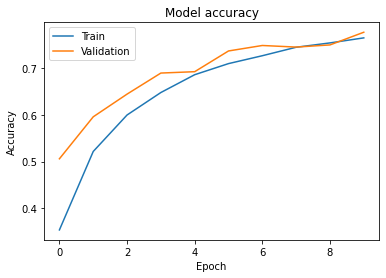

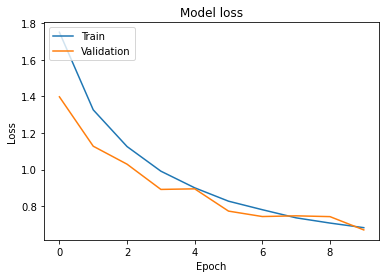

In [12]:
plt.figure()
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure()
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## RMSprop

In [13]:
model = Create_Model()
opt = optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07)
model, history = Train(model, opt, data_augmentation, x_train, y_train, 
                       x_test, y_test, batch_size, epochs)

Using real-time data augmentation.
Epoch 1/10
1562/1562 [==============================] - 119s 76ms/step - loss: 1.5352 - accuracy: 0.4490 - val_loss: 1.2293 - val_accuracy: 0.5700
Epoch 2/10
1562/1562 [==============================] - 122s 78ms/step - loss: 1.1172 - accuracy: 0.6060 - val_loss: 0.9984 - val_accuracy: 0.6597
Epoch 3/10
1562/1562 [==============================] - 119s 76ms/step - loss: 0.9642 - accuracy: 0.6655 - val_loss: 0.9461 - val_accuracy: 0.6756
Epoch 4/10
1562/1562 [==============================] - 118s 76ms/step - loss: 0.8936 - accuracy: 0.6948 - val_loss: 0.9018 - val_accuracy: 0.7041
Epoch 5/10
1562/1562 [==============================] - 125s 80ms/step - loss: 0.8818 - accuracy: 0.7034 - val_loss: 0.8404 - val_accuracy: 0.7246
Epoch 6/10
1562/1562 [==============================] - 125s 80ms/step - loss: 0.8739 - accuracy: 0.7050 - val_loss: 0.7299 - val_accuracy: 0.7593
Epoch 7/10
1562/1562 [==============================] - 132s 84ms/step - loss: 0.86

In [14]:
# model_name = 'keras_cifar10_model_RMSprop.h5'
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# model_path = os.path.join(save_dir, model_name)
# model.save(model_path)
# print('Saved trained model at %s ' % model_path)

# Score trained model.
scores = model.evaluate(x_test, y_test, verbose=1)
print(f'Test loss: {scores[0]:.4f}')
print(f'Test accuracy: {scores[1]:.4f}')

313/313 [==============================] - 5s 17ms/step - loss: 0.8246 - accuracy: 0.7306
Test loss: 0.8246
Test accuracy: 0.7306


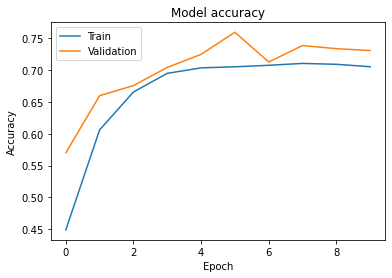

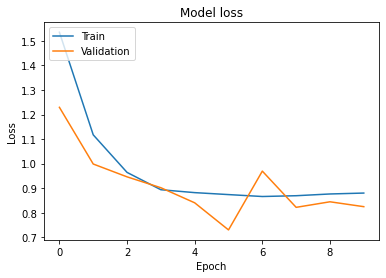

In [15]:
plt.figure()
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure()
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Adam

In [16]:
model = Create_Model()
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
model, history = Train(model, opt, data_augmentation, x_train, y_train, 
                       x_test, y_test, batch_size, epochs)

Using real-time data augmentation.
Epoch 1/10
1562/1562 [==============================] - 139s 88ms/step - loss: 1.4814 - accuracy: 0.4593 - val_loss: 1.1272 - val_accuracy: 0.5983
Epoch 2/10
1562/1562 [==============================] - 135s 86ms/step - loss: 1.0531 - accuracy: 0.6265 - val_loss: 0.9873 - val_accuracy: 0.6445
Epoch 3/10
1562/1562 [==============================] - 122s 78ms/step - loss: 0.8895 - accuracy: 0.6887 - val_loss: 0.7981 - val_accuracy: 0.7219
Epoch 4/10
1562/1562 [==============================] - 140s 90ms/step - loss: 0.7990 - accuracy: 0.7210 - val_loss: 0.7654 - val_accuracy: 0.7367
Epoch 5/10
1562/1562 [==============================] - 137s 87ms/step - loss: 0.7444 - accuracy: 0.7397 - val_loss: 0.7525 - val_accuracy: 0.7519
Epoch 6/10
1562/1562 [==============================] - 137s 88ms/step - loss: 0.6883 - accuracy: 0.7602 - val_loss: 0.7156 - val_accuracy: 0.7574
Epoch 7/10
1562/1562 [==============================] - 141s 90ms/step - loss: 0.65

In [17]:
# model_name = 'keras_cifar10_model_Adam.h5'
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# model_path = os.path.join(save_dir, model_name)
# model.save(model_path)
# print('Saved trained model at %s ' % model_path)

# Score trained model
scores = model.evaluate(x_test, y_test, verbose=1)
print(f'Test loss: {scores[0]:.4f}')
print(f'Test accuracy: {scores[1]:.4f}')

313/313 [==============================] - 5s 16ms/step - loss: 0.6579 - accuracy: 0.7805
Test loss: 0.6579
Test accuracy: 0.7805


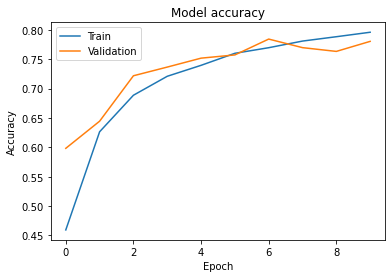

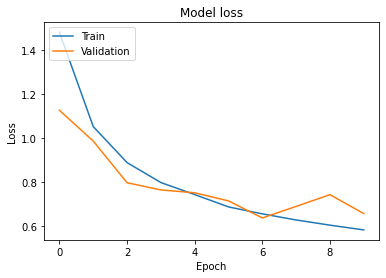

In [18]:
plt.figure()
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.figure()
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()